In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from numpy import asarray
from numpy import savetxt
import matplotlib.colors as mcolors
import matplotlib.cm
import matplotlib.patches as mpatches
import umap
import matplotlib as mpl
import scanpy as sc
import scipy
import kmapper as km
from kmapper import jupyter
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import sys
from sklearn import ensemble
from tqdm import tqdm
from ripser import Rips
from ripser import ripser
from persim import plot_diagrams
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
import numpy as np
import pandas as pd

df_1 = pd.read_csv("data/neuro_circ/sheet_1.csv", header=None).T
df_2 = pd.read_csv("data/neuro_circ/sheet_2.csv", header=None).T

# NOTE: within each of {df_1, df_2}, Cell_number is a unique ID,
# so each row (post-transpose) is a unique cell

# Set columns
df_1.columns = df_1.iloc[0]
df_1.drop(df_1.index[0], inplace=True)
df_2.columns = df_2.iloc[0]
df_2.drop(df_2.index[0], inplace=True)

names_1 = df_1["Animal_Number"].tolist()
names_2 = df_2["Animal_Number"].tolist()
names = names_1 + names_2
uniq_names = np.unique(names)

groups_1 = df_1["core_group"].tolist()
groups_2 = df_2["core_group"].tolist()
groups = groups_1 + groups_2
uniq_groups = np.unique(groups)

# Drop irrelevant columns
to_drop = ['Cell_number', 'Animal_Number', 'core_group',
	'Light_treat', 'Rostral_Caudal', 
	'Ventral_Dorsal', 'Medial_Lateral']
df_1.drop(labels=to_drop, axis=1, inplace=True)
df_2.drop(labels=to_drop, axis=1, inplace=True)

In [3]:
df_1 = df_1.replace(np.nan, 0)
df_2 = df_2.replace(np.nan, 0)

In [4]:
df_1

,atp5b,actb,hprt,adcyap1,adcyap1r1,arih1,arntl,avp,avpr1a,avpr1b,...,rora,rorb,rrad,slc12a4,slc12a5,slc12a6,slc12a7,slc32a1,vip,vipr2
1,11.427905,10.473388,11.822205,14.488351,12.218782,14.70728,13.98417,9.174094,12.928091,15.90314,...,12.379826,10.297312,17.101606,0,12.716441,12.512285,12.800332,11.247133,0,11.736093
2,10.375993,9.467238,11.618394,14.434151,11.674226,12.55509,13.96029,9.277377,14.646005,0,...,12.250543,11.077715,16.822197,18.76495,11.103901,13.168483,13.34399,11.417826,9.864983,12.233566
3,9.618044,8.977748,10.812744,12.732032,10.907962,12.713677,12.70844,7.771519,13.390757,17.61591,...,10.781564,9.865984,15.694089,21.38875,11.333625,12.347694,11.496511,10.414771,13.361135,10.384524
4,9.775943,9.91307,11.036002,14.071403,10.550981,11.957332,13.76389,7.832878,14.356155,17.47094,...,11.352798,9.232877,16.670633,18.46826,12.35239,12.667903,12.177202,10.679824,0,10.709374
5,12.686042,11.59274,12.693083,14.87578,13.427096,13.241615,15.44523,10.299707,13.472044,18.90516,...,13.568545,11.511935,19.342418,0,15.424195,13.282405,13.641781,12.616679,0,14.318459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,9.580311,8.330711,10.611918,12.545801,9.723988,11.657607,12.85881,12.171207,13.078578,16.38513,...,10.281333,10.960291,13.859012,16.95422,8.954469,12.633719,12.472299,10.06871,0,11.342993
320,9.873617,10.208107,11.731747,14.892288,10.751739,12.271228,14.9354,14.324289,17.632563,0,...,13.919624,12.101896,17.75635,18.08701,10.841824,12.911224,0,10.95554,0,0
321,11.465848,10.680454,12.35711,12.964112,11.260702,14.111714,0,13.345652,11.935388,13.83308,...,15.195935,13.121328,14.825464,19.611,11.89881,15.098163,16.276513,11.893528,0,14.406742
322,10.697249,10.363831,10.782091,12.542192,13.017265,12.217457,12.41133,9.357907,12.537242,13.70159,...,9.838474,10.121139,13.868002,0,10.8867,13.948413,12.304958,11.008472,14.195738,10.700364


In [5]:
df_2

,adcyap1,adcyap1r1,arih1,arntl,avp,avpr1a,avpr1b,avpr2,bhlhe40,bhlhe41,...,rora,rorb,rrad,slc12a4,slc12a5,slc12a6,slc12a7,slc32a1,vip,vipr2
1,0.186067037,-0.59675264,-1.509295243,0.5340807,1.346618988,0.889667885,0.87850086,0.547521573,-1.011221897,0.202435747,...,-0.178929883,1.152300412,-8.02E-01,-8.259540949,-0.999106885,1.230994572,0.963954411,0.3318397767,-15.25999699,0.6368456
2,-0.5136915,-0.80615376,-0.11106341,-0.19599515,0.489377814,-1.582203822,-9.34739808,-8.432517214,-1.153781033,0,...,-0.80360484,-0.382060705,-1.28E+00,-0.4372193503,-0.140525242,-0.1791618345,-0.333661115,-0.59281107,1.01800782,-0.614584997
3,0.504064191,-0.72425369,-0.954014159,0.3714868,1.31087227,-1.011318891,-2.27258734,-1.066429523,-0.618590802,-0.040064119,...,-0.018988919,0.145307252,-8.33E-01,-3.745383799,-1.054612651,-0.0427362935,0.829454176,-0.274119449,-3.16250741,0.550094004
4,-0.396480186,0.07155363,0.241157464,-0.2451338,1.688339537,-1.537890428,-1.68879492,0,-1.806103939,-0.054065136,...,-0.151396346,1.21724021,-1.37E+00,-0.3860677463,-1.634550498,0.0758815895,0.587590099,-0.100345606,-15.25999699,0.664070347
5,0.881426743,-0.72227789,1.039157763,0.15581158,1.303794007,1.428503971,-1.04073539,-0.151479581,-2.62654351,0.313657963,...,-0.284860407,1.020466418,-1.96E+00,-8.259540949,-2.624072538,1.543663229,1.205294368,0.0450822833,-15.25999699,-0.862731833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.395096983,0.16452162,-0.193142597,-0.07408209,-3.384014264,-0.994339349,-1.33700572,-1.234496731,0.03313403,0.829290065,...,0.186043323,-1.244199072,7.07E-01,0.3939515127,1.029345357,-0.6239601115,-0.441532942,-0.223257847,-15.25999699,-0.703574534
320,-0.854546234,0.23361426,0.290079966,-1.05382655,-4.440252481,-4.451479986,-9.34739808,0.053820452,-1.921736647,-0.683323724,...,-2.355404294,-1.288959529,-2.09E+00,0.3580006153,0.238834304,0.1953794612,-8.305822815,-0.0132438943,-15.25999699,-14.047364
321,1.970276413,0.62129901,-0.653758807,-9.64844927,-2.564968343,2.142341821,3.208529,3.025562179,1.79268837,0.912747993,...,-2.735067827,-1.411745092,1.73E+00,-0.269343267,0.078494652,-1.094912991,-2.252255372,-0.0545845167,-15.25999699,-1.773832693
322,1.505449893,-2.02201105,0.353751803,1.48013854,0.536029616,0.653741001,2.4532722,2.072669469,0.08465263,-0.001904727,...,1.7356459,0.701697368,1.80E+00,-8.259540949,0.203857812,-0.8319099812,0.832552238,-0.0562754367,-3.18556569,1.045798327


In [86]:
reducer = umap.UMAP()
UMAP = reducer.fit_transform(df_2.values)
print(UMAP.shape)

#savetxt('cellcycle_umap.csv', UMAP, delimiter=',')

(323, 2)


No handles with labels found to put in legend.


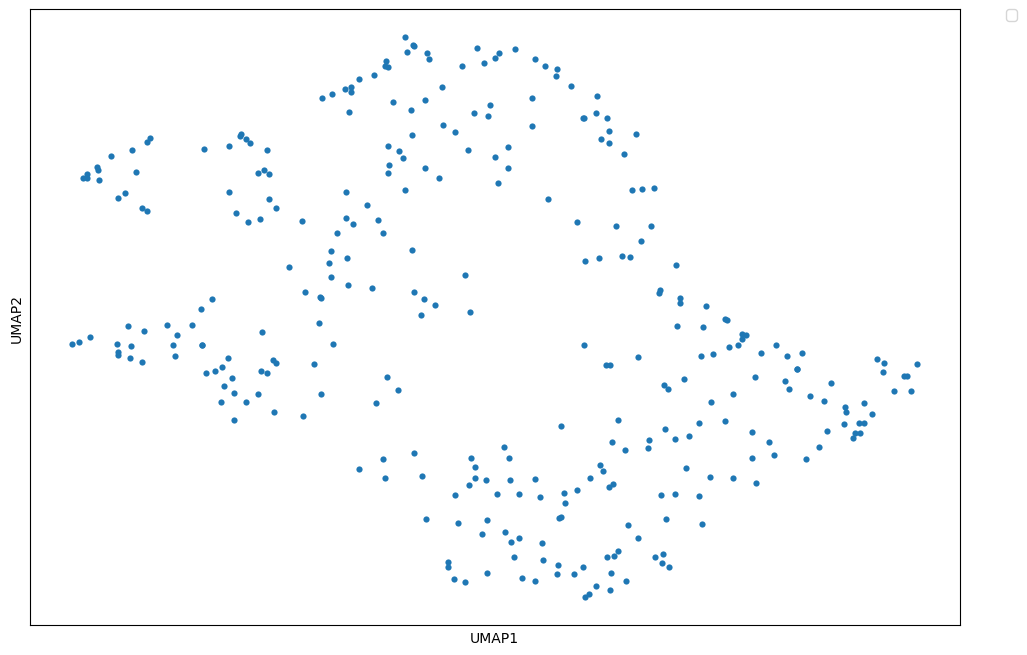

In [87]:
plt.figure(figsize=(12, 8))
frame1 = sns.scatterplot(UMAP[:,0], UMAP[:,1], s=20,  linewidth = 0)
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [93]:
np_data = df_1.values.T
N, d = np_data.shape
 
dist_mat = euclidean_distances(np_data, np_data)

In [94]:
print(dist_mat.shape)

(90, 90)


In [98]:
UMAP.shape

(323, 2)

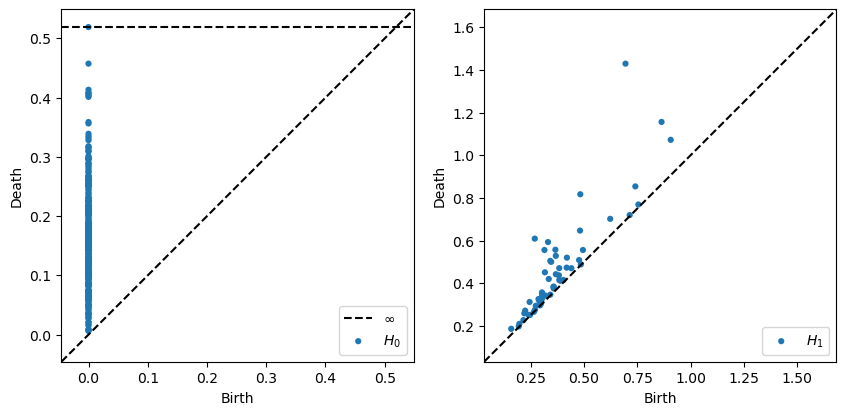

In [99]:
dgms = ripser(UMAP, maxdim=1)['dgms']


plt.figure(figsize=(10, 5))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(121))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(122))

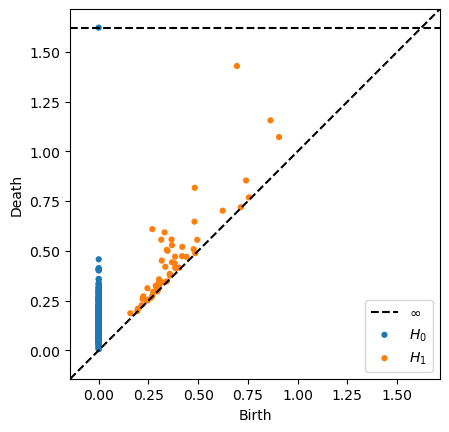

In [100]:
plot_diagrams(dgms, show=True)

In [28]:
np_data_concat = np.zeros((646,1))
for col in df_2.columns:
    A = df_1[col]
    B = df_2[col]
    np_data_concat = np.append(np_data_concat, np.reshape(np.append(A,B), (646,1)), axis = 1)
np_data_concat = np_data_concat[:,1:]
pd_data_concat = pd.DataFrame(np_data_concat, columns = df_2.columns)

dist_mat = euclidean_distances(np_data_concat, np_data_concat)
print(dist_mat.shape)

(646, 646)


In [29]:
pd_data_concat

,adcyap1,adcyap1r1,arih1,arntl,avp,avpr1a,avpr1b,avpr2,bhlhe40,bhlhe41,...,rora,rorb,rrad,slc12a4,slc12a5,slc12a6,slc12a7,slc32a1,vip,vipr2
0,14.488351,12.218782,14.70728,13.98417,9.174094,12.928091,15.90314,16.23651,15.450374,11.726925,...,12.379826,10.297312,17.101606,0,12.716441,12.512285,12.800332,11.247133,0,11.736093
1,14.434151,11.674226,12.55509,13.96029,9.277377,14.646005,0,24.46259,14.838976,11.175403,...,12.250543,11.077715,16.822197,18.76495,11.103901,13.168483,13.34399,11.417826,9.864983,12.233566
2,12.732032,10.907962,12.713677,12.70844,7.771519,13.390757,17.61591,16.41214,13.619422,10.531104,...,10.781564,9.865984,15.694089,21.38875,11.333625,12.347694,11.496511,10.414771,13.361135,10.384524
3,14.071403,10.550981,11.957332,13.76389,7.832878,14.356155,17.47094,15.78454,15.245762,10.983931,...,11.352798,9.232877,16.670633,18.46826,12.35239,12.667903,12.177202,10.679824,0,10.709374
4,14.87578,13.427096,13.241615,15.44523,10.299707,13.472044,18.90516,18.0183,18.148485,12.698492,...,13.568545,11.511935,19.342418,0,15.424195,13.282405,13.641781,12.616679,0,14.318459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,0.395096983,0.16452162,-0.193142597,-0.07408209,-3.384014264,-0.994339349,-1.33700572,-1.234496731,0.03313403,0.829290065,...,0.186043323,-1.244199072,7.07E-01,0.3939515127,1.029345357,-0.6239601115,-0.441532942,-0.223257847,-15.25999699,-0.703574534
642,-0.854546234,0.23361426,0.290079966,-1.05382655,-4.440252481,-4.451479986,-9.34739808,0.053820452,-1.921736647,-0.683323724,...,-2.355404294,-1.288959529,-2.09E+00,0.3580006153,0.238834304,0.1953794612,-8.305822815,-0.0132438943,-15.25999699,-14.047364
643,1.970276413,0.62129901,-0.653758807,-9.64844927,-2.564968343,2.142341821,3.208529,3.025562179,1.79268837,0.912747993,...,-2.735067827,-1.411745092,1.73E+00,-0.269343267,0.078494652,-1.094912991,-2.252255372,-0.0545845167,-15.25999699,-1.773832693
644,1.505449893,-2.02201105,0.353751803,1.48013854,0.536029616,0.653741001,2.4532722,2.072669469,0.08465263,-0.001904727,...,1.7356459,0.701697368,1.80E+00,-8.259540949,0.203857812,-0.8319099812,0.832552238,-0.0562754367,-3.18556569,1.045798327


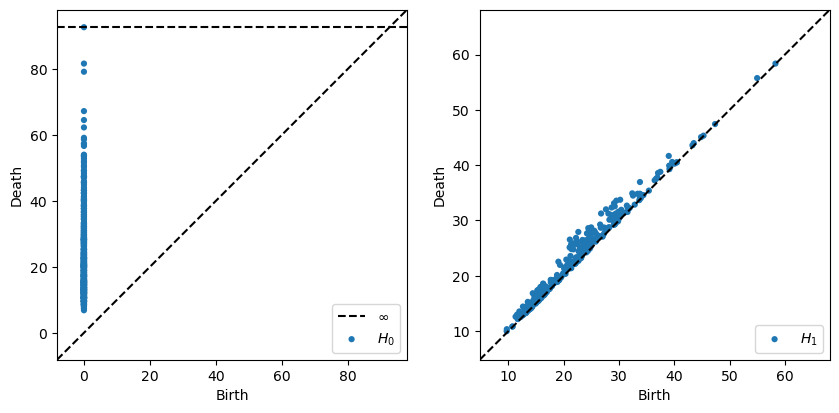

In [30]:
dgms = ripser(np_data_concat, maxdim=1)['dgms']


plt.figure(figsize=(10, 10))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(221))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(222))

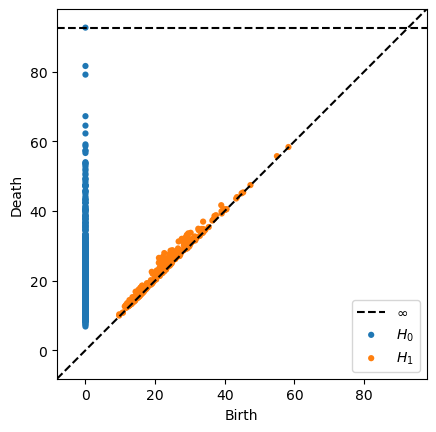

In [31]:
plot_diagrams(dgms, show=True)

In [39]:
from time import time
import numpy as np
from tda_utils.density_filtration import sort_distances_per_point, indices_for_density_filtration
from tda_utils.witness_complex import *

dist_per_pt = sort_distances_per_point(dist_mat)

# Load in ILC data
sct_sparse = np_data_concat
dist_mat = dist_mat
n, d = sct_sparse.shape
print("n = "+str(n))
print("d = "+str(d))
print("shape of dist_mat: "+str(dist_mat.shape))

# Load in distances per point
distances_per_point = dist_per_pt

# time computation of density filtrations
print("Timing computation of density filtrations...")
density_indices = dict()
density_filtrations = dict()
ks = [10, 100]
#      10000]
ps = [0.01, 0.05, 0.1, 0.2]
for k in ks:
    for p in ps:
        print("\tk = "+str(k)+", p = "+str(p)+":")
        start = time()
        indices = indices_for_density_filtration(distances_per_point, k, p)
        density_indices[(k, p)] = indices
        mask = np.zeros(n, dtype=bool)
        mask[indices] = True
        sqr_mask = np.outer(mask, mask)
        density_filtrations[(k, p)] = np.reshape(dist_mat[sqr_mask], (len(indices), len(indices)))
        print("\t"+str(time()-start)+" seconds\n")

print("Timing computation of landmarks...")
landmark_indices = dict()
landmark_mats = dict()
pps = [0.05, 0.1, 0.2]
for k in ks:
    for p in ps:
        for pp in pps:
            print("\tk = "+str(k)+", p = "+str(p)+", pp = "+str(pp)+":")
            start = time()
            landmark_indices[(k, p, pp)], landmark_mats[(k, p, pp)] = choose_landmarks(density_filtrations[(k, p)], pp)
            print("\t"+str(time()-start)+" seconds\n")

print("Printing numbers of landmarks...")
for k in ks:
    for p in ps:
        for pp in pps:
            toople = (k, p, pp)
            print(str(toople)+": "+str(len(landmark_indices[toople])))
            if toople == (100, 0.2, 0.2):
                print("saving")
                landmark_inds = landmark_indices[toople]
                dense_inds = density_indices[(k, p)]
                true_inds = [dense_inds[ind] for ind in landmark_inds]
                print(true_inds)
                to_save = np.vstack([sct_sparse[ind, :] for ind in true_inds])
                np.save("PanSquam_landmarks.npy", to_save)
                np.save("PanSquam_Racute_landmark_indices.npy", true_inds)
                
print(true_inds)

n = 646
d = 87
shape of dist_mat: (646, 646)
Timing computation of density filtrations...
	k = 10, p = 0.01:
	0.0010004043579101562 seconds

	k = 10, p = 0.05:
	0.0009999275207519531 seconds

	k = 10, p = 0.1:
	0.0 seconds

	k = 10, p = 0.2:
	0.0010001659393310547 seconds

	k = 100, p = 0.01:
	0.0 seconds

	k = 100, p = 0.05:
	0.0010004043579101562 seconds

	k = 100, p = 0.1:
	0.0010001659393310547 seconds

	k = 100, p = 0.2:
	0.0 seconds

Timing computation of landmarks...
	k = 10, p = 0.01, pp = 0.05:
	0.0 seconds

	k = 10, p = 0.01, pp = 0.1:
	0.0 seconds

	k = 10, p = 0.01, pp = 0.2:
	0.0 seconds

	k = 10, p = 0.05, pp = 0.05:
	0.0 seconds

	k = 10, p = 0.05, pp = 0.1:
	0.0 seconds

	k = 10, p = 0.05, pp = 0.2:
	0.0 seconds

	k = 10, p = 0.1, pp = 0.05:
	0.0 seconds

	k = 10, p = 0.1, pp = 0.1:
	0.0010004043579101562 seconds

	k = 10, p = 0.1, pp = 0.2:
	0.0 seconds

	k = 10, p = 0.2, pp = 0.05:
	0.0 seconds

	k = 10, p = 0.2, pp = 0.1:
	0.0 seconds

	k = 10, p = 0.2, pp = 0.2:
	0.

In [40]:
landmarks = true_inds
print(landmarks)

[436, 558, 559, 384, 505, 425, 570, 369, 580, 483, 368, 572, 549, 582, 444, 454, 546, 552, 612, 478, 495, 586, 621, 458, 531, 464]


No handles with labels found to put in legend.


(646, 2)


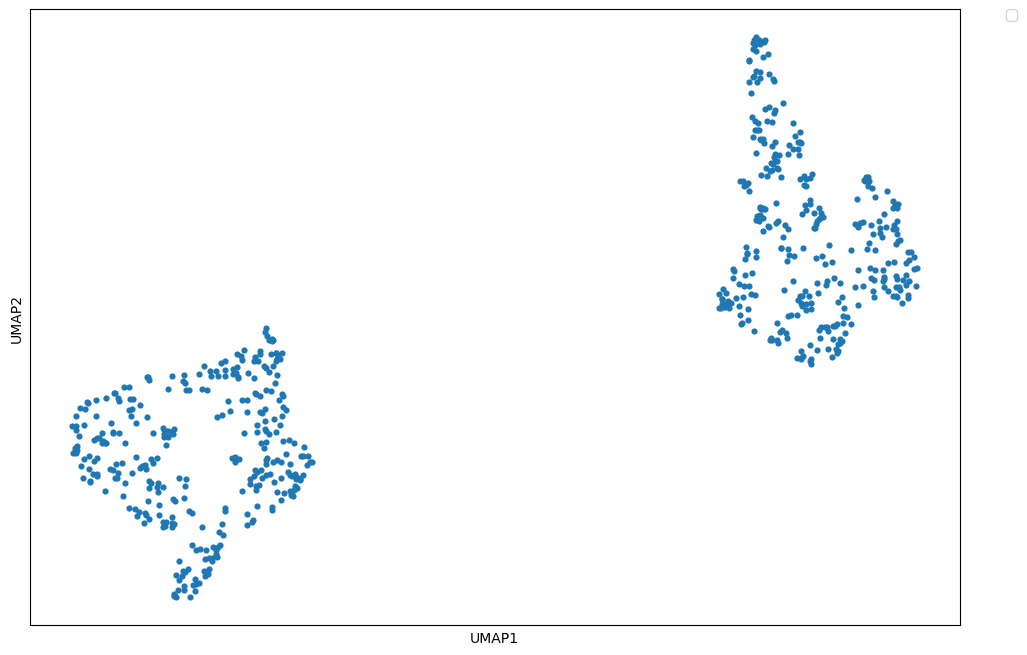

In [51]:
reducer = umap.UMAP()
UMAP = reducer.fit_transform(np_data_concat)
print(UMAP.shape)

plt.figure(figsize=(12, 8))
frame1 = sns.scatterplot(UMAP[:,0], UMAP[:,1], s=20,  linewidth = 0)
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

(1, 646)


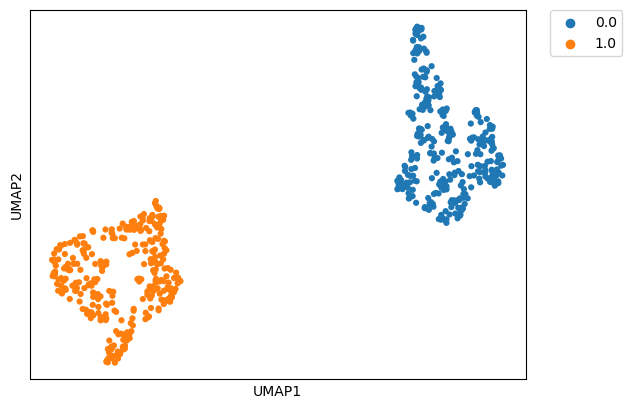

In [52]:
A = np.zeros((1,323))
B = np.ones((1,323))
label = np.append(A,B,axis = 1)
print(label.shape)

frame1 = sns.scatterplot(UMAP[:,0], UMAP[:,1], s=20,  linewidth = 0, hue = label[0,:])
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [45]:
N, d = np_data_concat.shape
genes = pd_data_concat.columns

UMAP = np.array(UMAP)
print(UMAP.shape)

UMAP_landmark = np.zeros((1,2))
data_landmark = np.zeros((1,d))

#Going through all of the cells, if index in landmarks we should pull the associated gene expression data
for i in landmarks:
    next_cell = np_data_concat[i,:]
    next_cell = np.reshape(next_cell, (1, d))
    data_landmark = np.append(data_landmark, next_cell, axis = 0)
        
    next_embedding = UMAP[i,:]
    next_embedding = np.reshape(next_embedding, (1,2))
    UMAP_landmark = np.append(UMAP_landmark, next_embedding, axis = 0)

#To get the indices to work out I have a row of zeros at the top that I need to omit
data_landmark = data_landmark[1:, :]    
UMAP_landmark = UMAP_landmark[1:, :]

print(data_landmark.shape)
print(UMAP_landmark.shape)

(646, 2)
(26, 87)
(26, 2)


In [ ]:
plt.figure(figsize=(12, 8))
frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=1, c = "silver")
frame1 = plt.scatter(UMAP_landmark[:,0], UMAP_landmark[:,1], s=1, c = "red")
plt.title('Racute - UMAP')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

In [102]:
from sklearn.decomposition import PCA

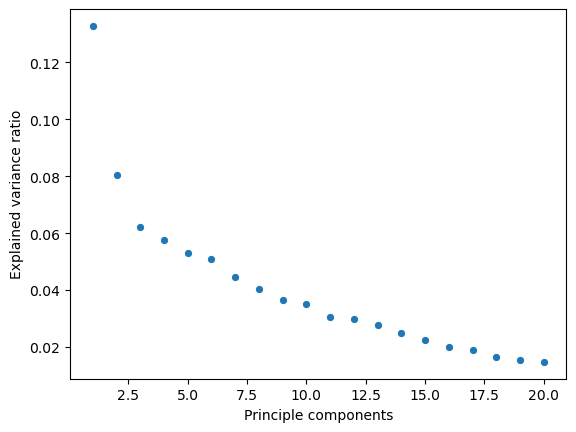

In [103]:
pca = PCA(n_components=20)
pca.fit(df_1.values)
PC = pca.transform(df_1.values)

var = np.array(pca.explained_variance_ratio_)
pcs = np.arange(1,21)

sns.scatterplot(pcs, var)
plt.ylabel('Explained variance ratio')
plt.xlabel('Principle components')
plt.show()

In [112]:
data = PC[:,0:10]

No handles with labels found to put in legend.


(323, 2)


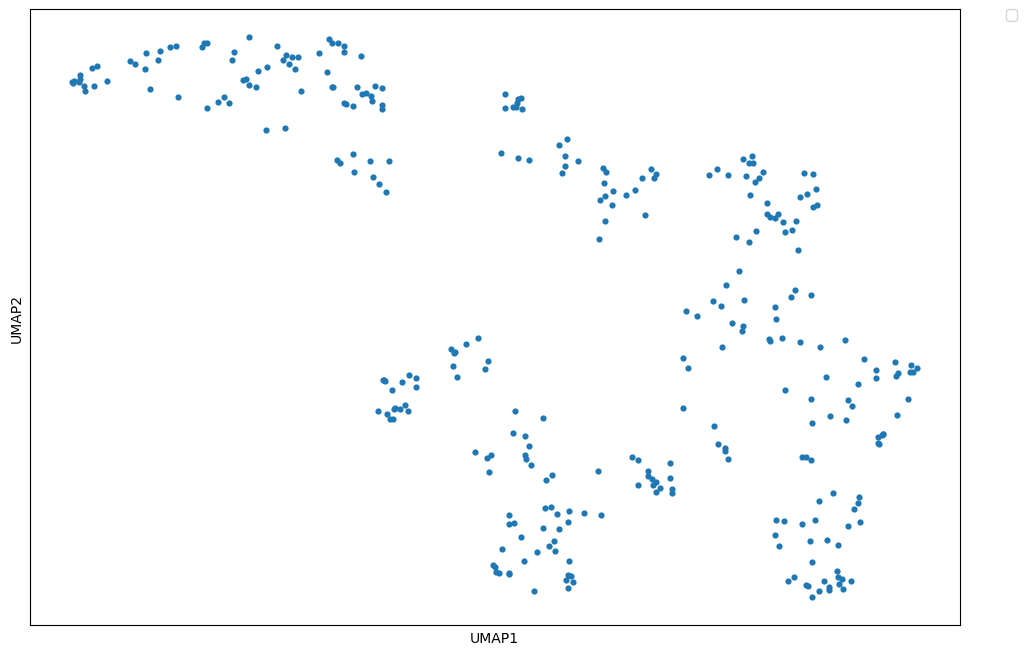

In [113]:
reducer = umap.UMAP()
UMAP = reducer.fit_transform(data)
print(UMAP.shape)

plt.figure(figsize=(12, 8))
frame1 = sns.scatterplot(UMAP[:,0], UMAP[:,1], s=20,  linewidth = 0)
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

(323, 10)


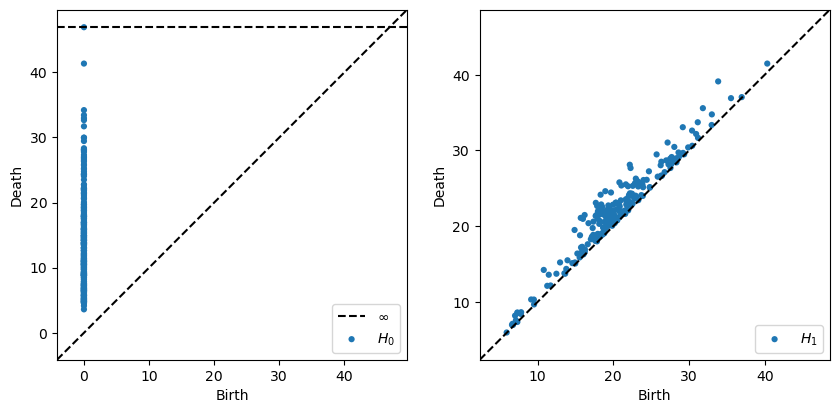

In [114]:
print(data.shape)
dgms = ripser(data, maxdim=1)['dgms']


plt.figure(figsize=(10, 10))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(221))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(222))

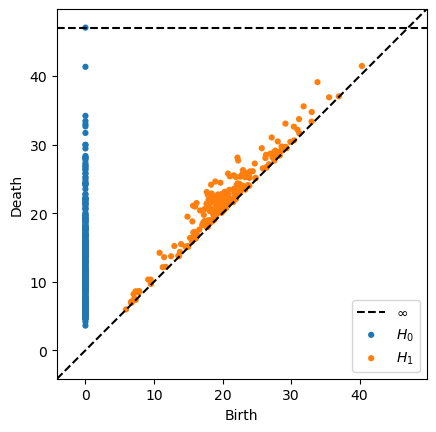

In [115]:
plot_diagrams(dgms, show=True)

In [117]:
df_2

,adcyap1,adcyap1r1,arih1,arntl,avp,avpr1a,avpr1b,avpr2,bhlhe40,bhlhe41,...,rora,rorb,rrad,slc12a4,slc12a5,slc12a6,slc12a7,slc32a1,vip,vipr2
1,0.186067037,-0.59675264,-1.509295243,0.5340807,1.346618988,0.889667885,0.87850086,0.547521573,-1.011221897,0.202435747,...,-0.178929883,1.152300412,-8.02E-01,-8.259540949,-0.999106885,1.230994572,0.963954411,0.3318397767,-15.25999699,0.6368456
2,-0.5136915,-0.80615376,-0.11106341,-0.19599515,0.489377814,-1.582203822,-9.34739808,-8.432517214,-1.153781033,0,...,-0.80360484,-0.382060705,-1.28E+00,-0.4372193503,-0.140525242,-0.1791618345,-0.333661115,-0.59281107,1.01800782,-0.614584997
3,0.504064191,-0.72425369,-0.954014159,0.3714868,1.31087227,-1.011318891,-2.27258734,-1.066429523,-0.618590802,-0.040064119,...,-0.018988919,0.145307252,-8.33E-01,-3.745383799,-1.054612651,-0.0427362935,0.829454176,-0.274119449,-3.16250741,0.550094004
4,-0.396480186,0.07155363,0.241157464,-0.2451338,1.688339537,-1.537890428,-1.68879492,0,-1.806103939,-0.054065136,...,-0.151396346,1.21724021,-1.37E+00,-0.3860677463,-1.634550498,0.0758815895,0.587590099,-0.100345606,-15.25999699,0.664070347
5,0.881426743,-0.72227789,1.039157763,0.15581158,1.303794007,1.428503971,-1.04073539,-0.151479581,-2.62654351,0.313657963,...,-0.284860407,1.020466418,-1.96E+00,-8.259540949,-2.624072538,1.543663229,1.205294368,0.0450822833,-15.25999699,-0.862731833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.395096983,0.16452162,-0.193142597,-0.07408209,-3.384014264,-0.994339349,-1.33700572,-1.234496731,0.03313403,0.829290065,...,0.186043323,-1.244199072,7.07E-01,0.3939515127,1.029345357,-0.6239601115,-0.441532942,-0.223257847,-15.25999699,-0.703574534
320,-0.854546234,0.23361426,0.290079966,-1.05382655,-4.440252481,-4.451479986,-9.34739808,0.053820452,-1.921736647,-0.683323724,...,-2.355404294,-1.288959529,-2.09E+00,0.3580006153,0.238834304,0.1953794612,-8.305822815,-0.0132438943,-15.25999699,-14.047364
321,1.970276413,0.62129901,-0.653758807,-9.64844927,-2.564968343,2.142341821,3.208529,3.025562179,1.79268837,0.912747993,...,-2.735067827,-1.411745092,1.73E+00,-0.269343267,0.078494652,-1.094912991,-2.252255372,-0.0545845167,-15.25999699,-1.773832693
322,1.505449893,-2.02201105,0.353751803,1.48013854,0.536029616,0.653741001,2.4532722,2.072669469,0.08465263,-0.001904727,...,1.7356459,0.701697368,1.80E+00,-8.259540949,0.203857812,-0.8319099812,0.832552238,-0.0562754367,-3.18556569,1.045798327


In [119]:
ls = ["rora","drd1a","prokr2","arntl","egr2","rasd1","per2","rasa1","cry1","gabra1","csnk1e","gsk3b","adcyap1r1","egr1"]
pd_data = df_2[ls]

No handles with labels found to put in legend.


(323, 2)


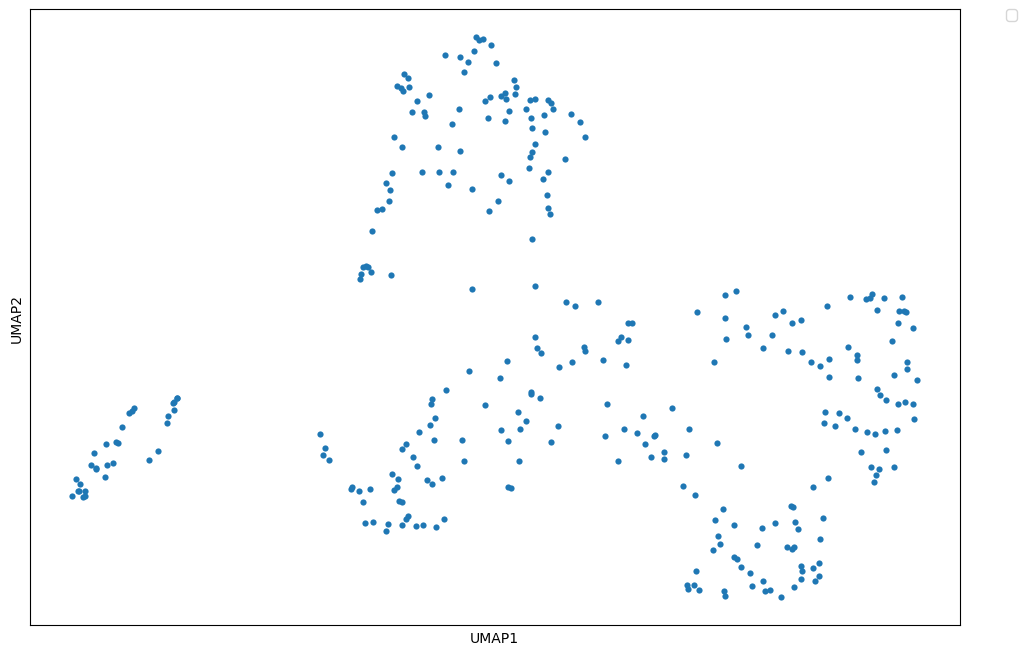

In [120]:
reducer = umap.UMAP()
UMAP = reducer.fit_transform(pd_data.values)
print(UMAP.shape)

plt.figure(figsize=(12, 8))
frame1 = sns.scatterplot(UMAP[:,0], UMAP[:,1], s=20,  linewidth = 0)
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

(323, 14)


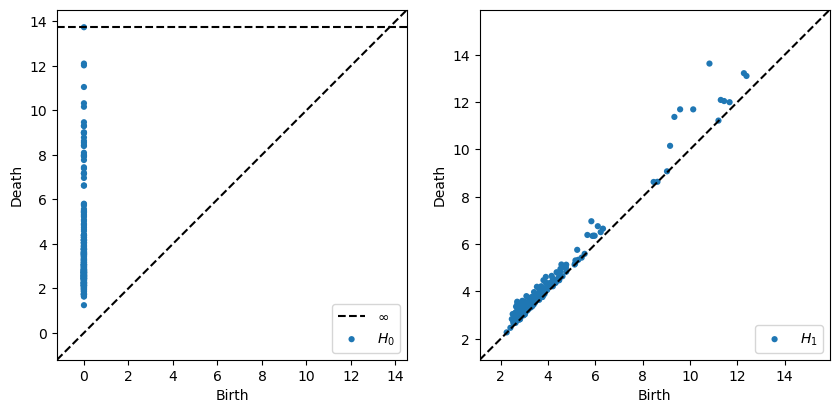

In [121]:
print(pd_data.values.shape)
dgms = ripser(pd_data.values, maxdim=1)['dgms']


plt.figure(figsize=(10, 10))
plot_diagrams(dgms, plot_only=[0], ax=plt.subplot(221))
plot_diagrams(dgms, plot_only=[1], ax=plt.subplot(222))

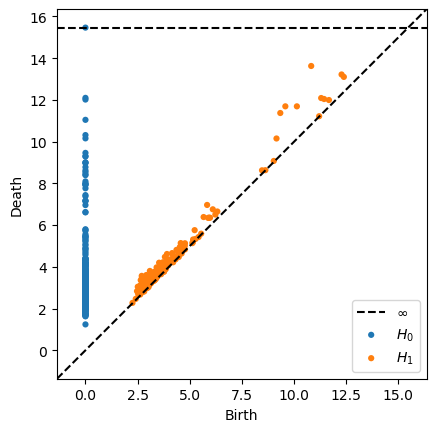

In [122]:
plot_diagrams(dgms, show=True)